# Basic Transcriptomics

In this exercise we'll use data from an upcoming publication by Dr. Jill Lawrence.
In the experiment she applied extracellular Tat and/or Stimulation to microglia and then used Illumina's RNA-seq kit.
The library was sequenced by the Genomics Core and I ran the `nfcore/rnaseq` pipeline.
This data uses the `salmon` gene count file.

In [2]:
# Data-science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

import warnings
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

/opt/tljh/user/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Data

Read in the data using `pandas` just like in Biostats.

In [3]:
# The data is stored centrally
PREFIX = '/data/share/OMICS/wk12'

### Sample Sheet

In [4]:
sample_sheet = pd.read_csv(f'{PREFIX}/061124_info_sheet.csv')

# Enforce order on categorical variables
sample_sheet['timepoint'] = pd.Categorical(sample_sheet['timepoint'], categories = ['4X', '6X'])
sample_sheet['Stim'] = pd.Categorical(sample_sheet['Stim'], categories = ['No', 'Yes'])
sample_sheet['Tat'] = pd.Categorical(sample_sheet['Tat'], categories = ['No', 'Tat50', 'Tat250'])
sample_sheet.set_index('sample', inplace=True)
sample_sheet.head()

,set,timepoint,treatment,Stim,Tat,replicate
sample,,,,,,
d_4X_A_3,d,4X,Control,No,No,3
d_4X_A_5,d,4X,Control,No,No,5
d_4X_B_3,d,4X,Stim,Yes,No,3
d_4X_B_6,d,4X,Stim,Yes,No,6
d_4X_C_1,d,4X,Tat50,No,Tat50,1


In [10]:
pd.pivot_table(sample_sheet.reset_index(),
               columns = 'timepoint',
               index = 'treatment',
               values = 'sample', aggfunc = 'count')

timepoint,4X,6X
treatment,,
Control,3,3
Stim,3,3
Stim+Tat50,3,0
Tat250,3,0
Tat50,3,3


### Read in transcriptome

In [6]:
rna_matrix = pd.read_csv(f'{PREFIX}/salmon.merged.gene_counts_scaled.tsv', sep='\t')
rna_matrix.columns.name = 'sample_id'
rna_matrix = rna_matrix.drop(['gene_id'], axis=1).set_index('gene_name')

rna_matrix.head()

sample_id,d_4X_A_3,d_4X_A_5,d_4X_B_3,d_4X_B_6,d_4X_C_1,d_4X_C_2,d_4X_D_3,d_4X_D_4,e_6X_A_1,e_6X_A_2,...,e_6X_C_1,e_6X_C_2,e_6X_C_3,f_4X_A_3,f_4X_B_2,f_4X_C_3,f_4X_D_1,f_4X_E_1,f_4X_E_2,f_4X_E_3
gene_name,,,,,,,,,,,,,,,,,,,,,
TSPAN6,579.997449,670.796056,753.583611,855.584442,892.099878,825.672801,897.944840,962.936206,990.947271,941.639039,...,1009.886122,958.816696,1097.816304,428.189007,739.095710,718.458776,532.897250,690.195448,730.166563,687.294492
TNMD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DPM1,1206.254716,1157.522129,1679.123712,1750.388724,1599.583418,1481.866328,1393.648238,1201.971314,1490.713088,1147.784264,...,1406.764262,1412.018864,1586.665906,1068.414391,1424.129571,1289.057919,1134.743378,1616.195321,1452.886304,1534.150368
SCYL3,160.091504,173.177730,149.708446,195.993638,230.973798,211.801600,180.745414,181.522332,162.529619,150.575649,...,151.879717,160.948524,165.887777,110.013489,154.576306,120.697700,133.212596,148.840860,132.737098,126.888166
FIRRM,85.344948,109.265756,229.151140,394.533424,135.385094,123.958739,137.149077,83.538000,146.577100,127.908869,...,171.660604,134.574522,155.794883,36.318056,49.753586,54.231439,46.937852,60.127233,68.812440,41.919581


### Remove Unusable Rows

One thing to note about RNA-seq is that about half of genes are below the level of detection.

In [ ]:
# How many samples is a gene expressed in?
sample_count = (rna_matrix>0).sum(axis=1)

In [ ]:
sns.histplot(sample_count, bins = np.arange(26), stat='count')

More than 25,000 genes (about 40%) were not measured even once.
About 4000 genes were measured in only a single sample.
There are only ~17,000 genes that have any meaningful expression across multiple samples.

Having these in will mess up many downstream processes by artifically inflating our gene counts.
In this case I'm keep all genes expressed (>0) in at least 3 samples; this should still allow genes that are only expressed in a single condition to be captured.

In [11]:
expressed_genes = rna_matrix.loc[sample_count>=3]
print(f'All genes: {len(rna_matrix)}\nExpressed Genes: {len(expressed_genes)}')

NameError: name 'sample_count' is not defined

## Common Analyses

There are a handful of python libaries we can use.
If you're doing single-cell transcriptomics you should use `scanpy`.
However, it is a bit overkill when you only have a handful of samples.
We'll just use pandas/sklearn/statsmodels.
If you're doing something more in-depth, check out the scanpy tutorials.

### Dimensionality Reduction

This is the process of _projecting_ your data into fewer dimensions for visualization.
This can be useful as an initial screening to understand how samples cluster with each other.

In [7]:
from sklearn.decomposition import PCA

# Project each _sample_ into a smaller dimension

reduced = PCA(n_components=2).fit_transform(expressed_genes.T)
ax = sns.scatterplot(x = reduced[:,0], y = reduced[:, 1],
                hue = sample_sheet['treatment'])
ax.set_xlabel('PC1'), ax.set_ylabel('PC2')

NameError: name 'expressed_genes' is not defined

The samples of similar conditions should group together.
Here we see a "Stim" condition in the middle of a set of "Stim+Tat50" samples.
Perhaps the Tat was not effective in that sample?

We can also see that the controls are intermixed with the Tat only samples but the Stim conditions are distinct.
This is evidence that maybe there isn't a big effect of Tat.

### Visualization

Seaborn is the easiest way to visualize the expression of a few genes across different conditions.

<AxesSubplot: xlabel='treatment', ylabel='KLF5'>

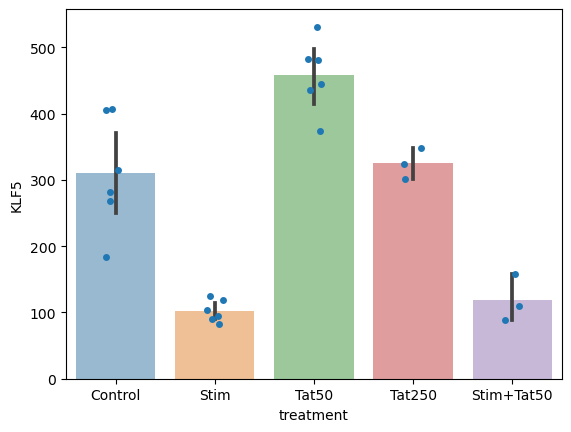

In [8]:
ax = sns.barplot(y = rna_matrix.loc['KLF5', sample_sheet.index],
                 x = sample_sheet['treatment'], alpha=0.5)

sns.stripplot(y = rna_matrix.loc['KLF5', sample_sheet.index],
              x = sample_sheet['treatment'], 
              ax=ax)

For single gene hypothesis testing, Pingouin is easiest for doing your statistics.

I suggest re-bookmarking the decision trees for each test: https://pingouin-stats.org/build/html/guidelines.html

In [ ]:
data = pd.DataFrame({'expression': rna_matrix.loc['KLF5', sample_sheet.index],
                     'treatment': sample_sheet['treatment']})

In [ ]:
# Test for normality assumption
pg.normality(data, dv = 'expression', group='treatment')

In [ ]:
# ANOVA between treatments

pg.anova(data, dv = 'expression' , between='treatment')

In [ ]:
# Pairwise follow-up

res = pg.pairwise_tukey(data, dv = 'expression', between='treatment')
res[res['p-tukey']<0.05]

### Heatmaps

<AxesSubplot: xlabel='sample_id', ylabel='gene_name'>

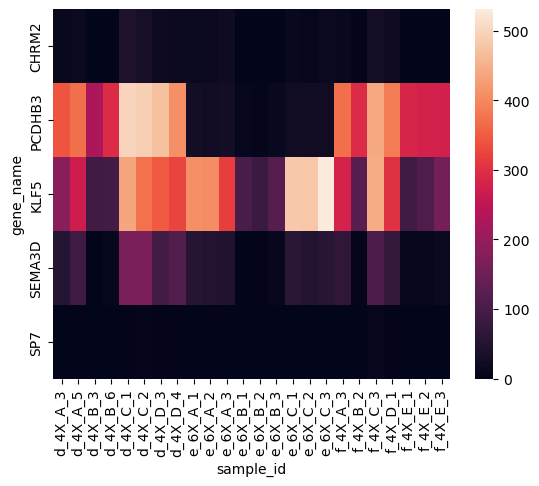

In [12]:
sns.heatmap(rna_matrix.loc[['CHRM2', 'PCDHB3', 'KLF5', 'SEMA3D', 'SP7']])

## Pairwise Comparisons

Most pipelines, including [`nfcore`](https://nf-co.re/rnaseq/3.17.0/docs/output/#deseq2), will perform basic pairwise comparisons between test & control groups.
This is usually done with DESeq2, an R package. Yuck.

We can do a similar analysis ourselves.

In [ ]:
sample_sheet.query('timepoint == "4X" &	Tat == "No"')

In [ ]:
no_stim = ['d_4X_A_3','d_4X_A_5', 'f_4X_A_3']
expressed_genes[no_stim].head()

In [ ]:
stimmed = ['d_4X_B_3','d_4X_B_6','f_4X_B_2']
expressed_genes[stimmed].head()

In [ ]:
# Calculate a log2 ratio of the difference in expression

log2rc = np.log2(expressed_genes[no_stim].mean(axis=1)/expressed_genes[stimmed].mean(axis=1))

In [ ]:
# When doing matrix level t-tests, the scipy package is easier.
from scipy.stats import ttest_ind

In [ ]:
# Calculate a p-value for each gene
_, pvals = ttest_ind(expressed_genes[no_stim], expressed_genes[stimmed], axis=1)
pval_ser = pd.Series(pvals, index=expressed_genes.index)

_, bh_pvals = pg.multicomp(pval_ser, alpha=0.05, method='fdr_bh')

In [ ]:
stim_results = pd.DataFrame({'log2FC': log2rc,
                            'pvals': pvals,
                            'bh_pvals': bh_pvals,
                            'mean_expression': expressed_genes[no_stim+stimmed].mean(axis=1)})
stim_results.head()


### Volcano plot

In [ ]:
sns.scatterplot(data = stim_results,
                x = 'log2FC',
                y = -np.log10(stim_results['bh_pvals']),
                alpha=0.5)

In [ ]:
ax = sns.scatterplot(data = stim_results,
                x = 'mean_expression',
                y = 'log2FC',
                alpha=0.1)
sns.scatterplot(data = stim_results[stim_results['bh_pvals']<0.05],
                x = 'mean_expression',
                y = 'log2FC', alpha=0.9)
ax.set_xscale('log')

### Linear Models

Instead of a standard _differential expression_ analysis which performs a standard two-group analysis, this uses a linear regression model.
In these types of analyses the each independent variable can interpreted together.
It also allows us to represent a more complex relationship between the different factors of the experimental design.

This idea was originally introduced in the R package `limma`.
I've re-implemented it over the years, here's an application to this project.

In [ ]:
from patsy import dmatrices
import statsmodels.api as smf
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm


def apply_formula(expression_matrix, sample_sheet, formula, min_frac_expressed = 0.5, fdr_alpha=0.1):
    "Apply a regression formula across each gene in the expression matrix. Applies FDR correction across p-values."
    
    info = sample_sheet.copy()
    info['expression'] = 0
    
    # The sample matrix will always be the same, so, precalc it
    # ~10X time saver
    _, X = dmatrices(formula, data=info, return_type='dataframe')
    
    
    drop_cols = ['Stim[T.Yes]:Tat[T.Tat250]',
                 'timepoint[T.6X]:Stim[T.Yes]:Tat[T.Tat250]',
                 'timepoint[T.6X]:Stim[T.Yes]:Tat[T.Tat50]',
                 'timepoint[T.6X]:Tat[T.Tat250]']

    X.drop(drop_cols, axis=1, inplace=True)

    results = []
    df_model = 0
    for key, row in tqdm(expression_matrix.iterrows(), total = len(expression_matrix.index)):
        if (row.notnull().sum()>10) & ((row>0).mean()>min_frac_expressed):
            
            zscaled = (row.values-row.mean())/row.std()
            
            full_model = smf.OLS(zscaled, X).fit()
            df_model = max(df_model, full_model.df_model)
            results.append(extract_effects_pvals(full_model))
        else:
            results.append(pd.Series({}))
            
            
    res_df = pd.DataFrame(results, index=expression_matrix.index)
    
    cols = [col for col in res_df.columns if col.endswith('pvalue')]

    pvals = res_df[cols]
    print(f'Applying p-value correction to {pvals.notnull().sum().sum()} tests')
    _, corrected, _, _ = multipletests(pvals.fillna(1).values.flatten(), method = 'fdr_bh', alpha=fdr_alpha)

    cor_df = pd.DataFrame(corrected.reshape(len(pvals.index), len(cols)), 
                          index=pvals.index,
                          columns = [col+'_cor' for col in cols])
    
    
    return pd.concat([res_df, cor_df], axis=1), df_model



def extract_effects_pvals(result):
    "Extract the p-values and effect sizes from a statsmodels result object"
    
    effects = result.params
    effects.index = [col + '_effect' for col in effects.index]
    
    pvals = result.pvalues
    pvals.index = [col + '_pvalue' for col in pvals.index]
    
    return pd.concat([effects, pvals])

def get_effect_names(columns):
    return sorted(set(col.split('_')[0] for col in columns))


def stripbarplot(alpha=0.5, **kwargs):
    "Make a plot of both dots and bars"
    
    sns.barplot(alpha=alpha, **kwargs)
    sns.stripplot(dodge=True, **kwargs)

    
def make_expression_figure(expression_matrix, sample_sheet, x='media', hue = 'treatment', figsize=(15, 25)):
    
    fig, axs = plt.subplots(3,3, figsize=figsize)

    info = sample_sheet.copy()
    for row, (ax, gene) in enumerate(zip(axs.flatten(), expression_matrix.index)):

        info['expression'] = expression_matrix.loc[gene].values

        stripbarplot(data = info,
                     y = 'expression',
                     x = x,
                     hue = hue,
                     ax=ax)

        sns.despine(ax=ax)
        if row != 0:
            if hue is not None:
                ax.legend().remove()

        ax.set_ylabel(gene)
        
    fig.tight_layout()
    return fig    


def volcano_plot(results_matrix, field, ax=None, **kwargs):
    
    if ax is None:
        _, ax = plt.subplots(1,1)
        
    return sns.scatterplot(x = results_matrix[field + '_effect'],
                           y = -np.log10(analysis_df[field + '_pvalue_cor']),
                           ax=ax,
                           **kwargs)

In [ ]:
formula = 'expression ~ timepoint*Stim*Tat'

In [ ]:
analysis_df, dof = apply_formula(expressed_genes, sample_sheet, formula)

In [ ]:
EFFECT_NAMES = get_effect_names(analysis_df.columns)

print(f'The regression had {int(dof)} degrees of freedom and there were {len(sample_sheet.index)} samples.')
print('These effects were determined.')
print(f'{"Name":50}Significant Genes')
for effect in EFFECT_NAMES:
    if not ((effect == 'Intercept') | effect.startswith('donor')):
        mask = analysis_df[effect + '_pvalue_cor'] < 0.01
        print(f'{effect:50}{mask.sum()}')

NameError: name 'EFFECT_NAMES' is not defined

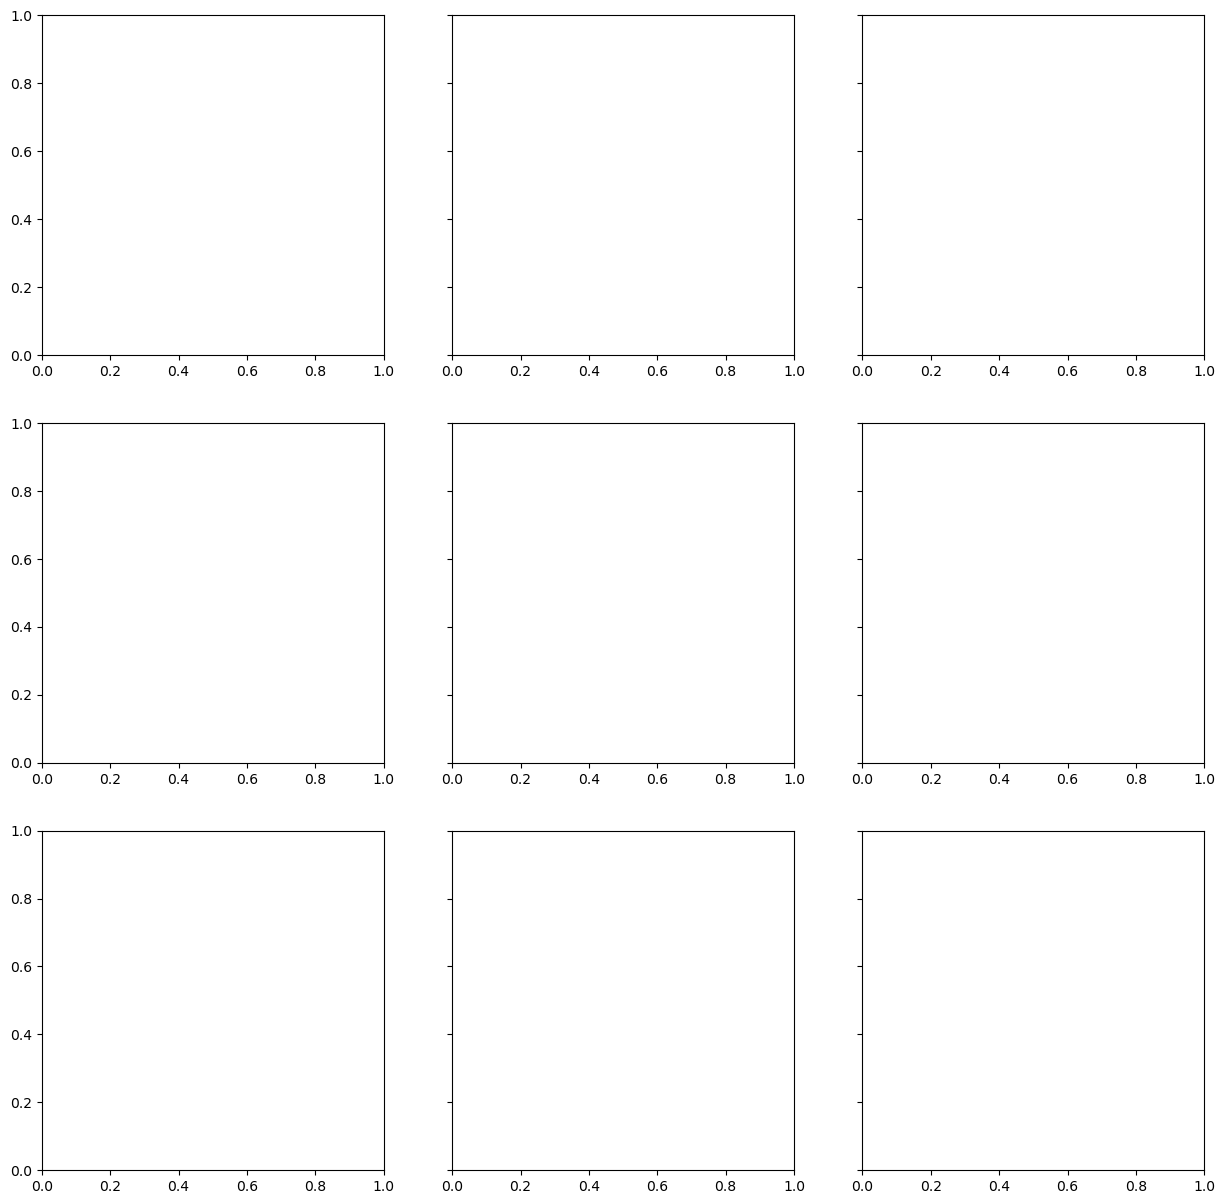

In [13]:
fig, axs = plt.subplots(3,3, sharey=True, figsize=(15,15))

experimental_effects = [ef for ef in EFFECT_NAMES if (not ef.startswith('donor')) & (ef != 'Intercept')]

for effect, ax in zip(experimental_effects, axs.flatten()):
    volcano_plot(analysis_df, effect, ax=ax)
    
    subplotspec = ax.get_subplotspec()
    if subplotspec.colspan.start == 0:
        ax.set_ylabel('-log10(BH-FDR)')
    
    ax.set_title(effect.replace(':', '\n'))
    ax.set_xlabel('effect (z-scale)')
    sns.despine(ax=ax, left = subplotspec.colspan.start != 0)
    ax.set_xlim(-5, 5)
    ax.axhline([2], linestyle = '--', color = 'k')
    ax.axvline([-0.5], linestyle = '--', color = 'k')
    ax.axvline([+0.5], linestyle = '--', color = 'k')
    
fig.tight_layout()
#fig.savefig('figures/volcano_plot_high.png', dpi=600)

In [1]:
for effect in experimental_effects:
    mask = analysis_df[effect + '_pvalue_cor'] < 0.01
    if mask.any():
        sig_gene_effects = analysis_df.loc[mask, effect + '_effect'].sort_values(ascending=False)
        
        fig = make_expression_figure(rna_matrix.loc[sig_gene_effects.index].sample(min(9, mask.sum())), sample_sheet,
                                     x='timepoint', hue = 'treatment',
                                     
                                     
                                     figsize=(10, 10))
        fig.suptitle(effect)
        fig.tight_layout()
        #fig.savefig(f'figures/{effect}-genes_sample.png', dpi=300)


NameError: name 'experimental_effects' is not defined